# Import libraries

In [9]:
import sys
sys.path.insert(0,'..')

In [10]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import colors
import h5py
import re
from typing import Optional
import datetime as dt
import matplotlib.patches as mpatches
from functools import partial
from multiprocessing import Pool

#from lhcsmapi.Time import Time
#from lhcsmapi.Timer import Timer
#from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from sklearn import preprocessing


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data
from src.visualisation.visualisation import make_gif
#from src.models.nmf import NMF
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el, generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Define Paths

In [11]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [13]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])

len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3981, 822)

In [14]:
mp3_fpa_df_unique['I_Q_kA'] = mp3_fpa_df_unique["I_Q_M"].apply(lambda x: np.round(x / 1e3)*1e3)
mp3_fpa_df_unique['dI_dt_from_data_round'] = mp3_fpa_df_unique["dI_dt_from_data"].apply(lambda x: int(np.round(x)))

mp3_fpa_df_unique['datetime'] = pd.to_datetime(mp3_fpa_df_unique['Date (FGC)'])
mp3_fpa_df_unique['year'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.year)
mp3_fpa_df_unique['month'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.month)
mp3_fpa_df_unique['day'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.day)

# Read metadata

In [6]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


In [7]:
mp3_fpa_df_unique = mp3_fpa_df_unique.merge(rb_magnet_metadata,
                                            left_on=["Magnet"],
                                            right_on=["Magnet"],
                                            how="left", suffixes=('', '_y'))

drop_columns = mp3_fpa_df_unique.filter(regex='Unnamed').columns.to_list()
drop_columns += mp3_fpa_df_unique.filter(regex='_y').columns.to_list()
mp3_fpa_df_unique = mp3_fpa_df_unique.drop(columns=drop_columns)

# Load description of context variables

In [8]:
df_feature_context = pd.read_excel("../data/metadata_context_variables.xlsx", engine='openpyxl', index_col="Unnamed: 0")

df_feature_context['nunique'] = mp3_fpa_df_unique[df_feature_context.index.values].nunique()
df_feature_context['nmissing'] = mp3_fpa_df_unique[df_feature_context.index.values].isna().sum()
df_feature_context

,dtype,ftype,one_hot,group,nunique,nmissing,units,comment
Circuit,<class 'str'>,event,True,circuit,8,0,NaN,['RB.A12' 'RB.A23' 'RB.A34' 'RB.A45' 'RB.A56' ...
timestamp_fgc,<class 'int'>,event,False,timing,822,0,[us],Unix timestamp of FPA
Delta_t(FGC-PIC),<class 'float'>,event,False,acquisition_systems,29,261,[ms],Difference in acquisition systems
Delta_t(EE_even-PIC),<class 'float'>,event,False,acquisition_systems,37,0,[ms],Difference in acquisition systems
Delta_t(EE_odd-PIC),<class 'float'>,event,False,acquisition_systems,48,0,[ms],Difference in acquisition systems
Delta_t(iQPS-PIC),<class 'float'>,event,False,acquisition_systems,37,0,[ms],Difference in acquisition systems
Delta_t(nQPS-PIC),<class 'float'>,event,False,acquisition_systems,48,263,[ms],Difference in acquisition systems
Plateau duration,<class 'float'>,event,False,operation,70,231,[s],Duration of stable current before FPA
t_EE_odd,<class 'float'>,event,False,acquisition_systems,48,0,[s],Time of activation of odd EE
t_EE_even,<class 'float'>,event,False,acquisition_systems,37,0,[s],Time of activation of odd EE


# Load Data

In [9]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

all_fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x) for x in dataset_2EE_fft.data])

data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

## Define training data

In [10]:
# all events with successfully loaded data
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)] 

# model is not trained on data before 2021 and events with fast secondary quenches
bool_R2 =  (mp3_fpa_df['timestamp_fgc'] < 1611836512820000000)
bool_fast = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) & (mp3_fpa_df['Nr in Q event'].astype(str) !='1')) 
bool_test = bool_R2 | bool_fast
            
fpa_identifiers_test = fpa_identifiers[np.isin(fpa_identifiers, mp3_fpa_df[bool_test].fpa_identifier.unique())]

bool_train = ~np.isin(fpa_identifiers, fpa_identifiers_test)
fpa_identifiers_train = fpa_identifiers[bool_train]
print(len(fpa_identifiers_train), len(fpa_identifiers_test))

# add dims for indexing flattended data
bool_train_1EE = np.stack([bool_train for l in range(data_1EE_ff_scaled.shape[1])]).T.reshape(-1)
bool_train_2EE = np.stack([bool_train for l in range(data_2EE_ff_scaled.shape[1])]).T.reshape(-1)

425 135


# <h1><center><font size="30">Non-negative components - NMF</font></center></h1>

<h1><font size="8">1st Energy Extraction Plateau</font></h1>

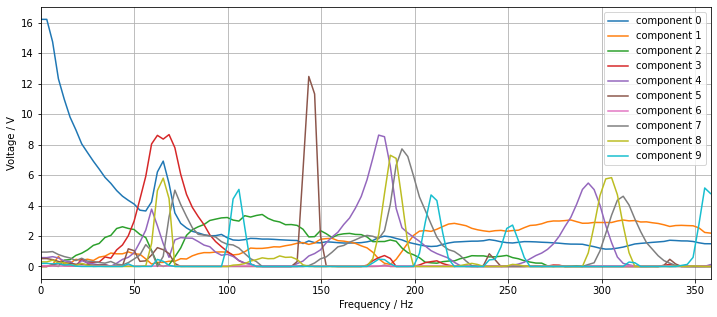

In [11]:
hyperparameter = {
    "n_components": 10,
    "solver": "cd",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-3,
    "max_iter": 200,
    "l1_ratio": 0.5,
    "alpha": 1,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=data_1EE[bool_train_1EE])
W_1EE = nmf_model.transform(X=data_1EE)
H_1EE = nmf_model.components_

plot_nmf_components(H_1EE, dataset_1EE_fft)

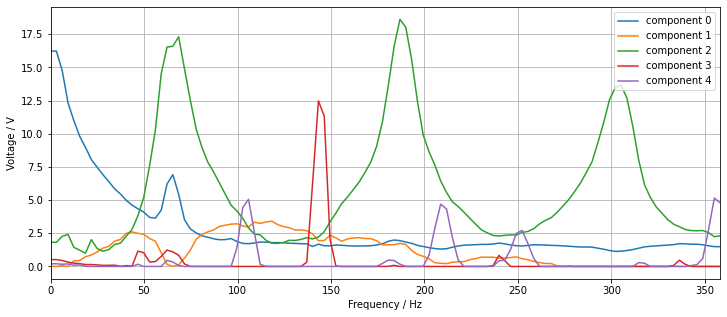

In [12]:
merge_component_index = [0, [2, 6], [1, 3, 4, 7, 8], 5, 9] #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #
H_1EE_merged = merge_array(H_1EE.T, merge_component_index, axis=-1, func=np.sum).T
W_1EE_merged = merge_array(W_1EE, merge_component_index, axis=-1, func=np.mean)

H_1EE_processed, component_weights_1EE = nmf_model.normalize_H(H=H_1EE_merged, W=W_1EE_merged)
plot_nmf_components(H_1EE_merged, dataset_1EE_fft)

## Check components

In [13]:
use_fpa_identifier = False
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A78_1617170255140000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 0 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

(0, array('RB_RB.A12_1543810849860000000', dtype='<U29'), nan)

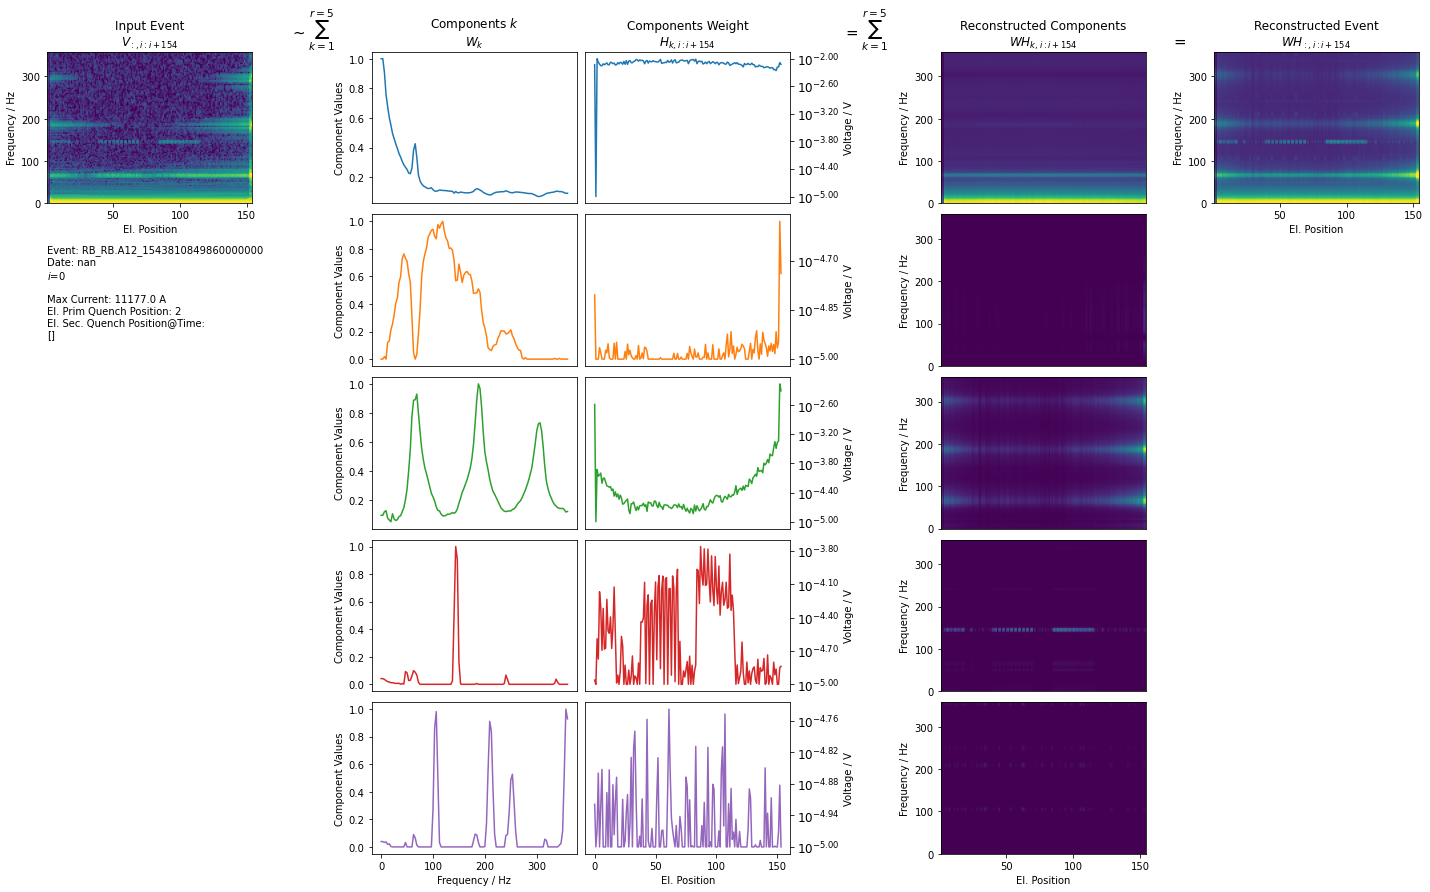

In [14]:
component_indexes_1EE = [0, 1, 2, 3, 4] 
plot_nmf_event_composition(data_1EE, component_weights_1EE, H_1EE_processed, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df)

## Calculate correlation matix event context

In [15]:
# define event and position data
df_event = mp3_fpa_df_unique.loc[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers), df_feature_context[(df_feature_context.ftype=='event')].index.values]
df_position = rb_magnet_metadata[df_feature_context[(df_feature_context.ftype=='position')].index.values]

# process event data
one_hot_columns = df_feature_context[(df_feature_context.ftype=='event') & (df_feature_context.one_hot==True)].index.values
df_event_processed = pd.get_dummies(df_event, columns=one_hot_columns)
scale_columns = df_feature_context[(df_feature_context.ftype=='event') &(df_feature_context.one_hot==False)].index.values
#df_event_processed[scale_columns] = ((df_event[scale_columns] - df_event[scale_columns].mean()) / df_event[scale_columns].std())[scale_columns]

# process position data
one_hot_columns = df_feature_context[(df_feature_context.ftype=='position') & (df_feature_context.one_hot==True)].index.values
df_position_processed  = pd.get_dummies(df_position, columns=one_hot_columns)
scale_columns = df_feature_context[(df_feature_context.ftype=='position') & (df_feature_context.one_hot==False)].index.values
#df_position_processed[scale_columns] = ((df_position[scale_columns] - df_position[scale_columns].mean()) / df_position[scale_columns].std())[scale_columns]

In [16]:
# create correlation table, size is (n_events, n_magnets, n_features) -> (560, 154, 121)
n_events = len(fpa_identifiers)
n_magnets = 154
n_features = df_event_processed.shape[-1] + 2*df_position_processed.shape[-1] + 2 #2 additional position features
data = np.zeros((n_events, n_magnets, n_features))


# iterate over events
data_list = []
for i, f in enumerate(fpa_identifiers):
    circuit = f.split('_')[1]
    timestamp_fgc = int(f.split('_')[2])
    quenched_magnet = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier ==f].Magnet.values[0]
    
    
    df_pos_data = df_position_processed[(rb_magnet_metadata.Circuit==circuit)].sort_values(by="El. Position")
    df_q_pos_data = df_position_processed[(rb_magnet_metadata.Circuit==circuit) & (rb_magnet_metadata.Magnet == quenched_magnet)].add_suffix('_q')
    df_event_data = df_event_processed[df_event.timestamp_fgc==timestamp_fgc]
    
    df_pos_data['El. Dist. to Quench'] = np.abs(df_pos_data['El. Position'].values - df_q_pos_data['El. Position_q'].values) #test
    df_pos_data['Phys. Dist. to Quench'] = np.abs(df_pos_data['Phys. Position'].values - df_q_pos_data['Phys. Position_q'].values)
    columns = df_pos_data.columns.to_list()
    
    df_pos_data[df_q_pos_data.columns] = np.repeat(df_q_pos_data.values, repeats=n_magnets, axis=0)
    df_pos_data[df_event_data.columns] = np.repeat(df_event_data.values, repeats=n_magnets, axis=0)
    
    all_columns = df_event_data.columns.to_list() + columns + df_q_pos_data.columns.to_list() 
    data_list.append(df_pos_data[all_columns])
    
df_data = pd.concat(data_list, axis=0).reset_index(drop=True)

In [17]:
# add compontents to table
c_columns = [f"H_{i}" for i in range(component_weights_1EE.shape[-1])]
df_y = pd.DataFrame(component_weights_1EE, columns = c_columns)
df = pd.concat([df_data, df_y], axis =1)

In [18]:
# calculate and save correlation
df_corr = df.corr()
#df_corr.to_excel('correlation.xlsx')

# Find outliers

# Analyze correlations

In [20]:
for c in df_feature_context.index.values:
    corr_index = df_corr.filter(regex=c.replace("(", "\(").replace(")", "\)")).columns.values
    df_corr.loc[corr_index, "group"] = df_feature_context.loc[c, "group"]
    
df_corr.loc[["El. Dist. to Quench" ,'Phys. Dist. to Quench'], "group"] = "position"

H_0
energy (+0.13)
magnet_type (+0.12)
position (+0.11)
H_1
magnet_type (+0.25)
timing (-0.20)
position (-0.17)
circuit (+0.16)
H_2
position (-0.46)
circuit (-0.20)
magnet_history (+0.15)
magnet_type (-0.14)
energy (+0.11)
H_3
circuit (+0.33)
operation (-0.12)
magnet_type (-0.12)
H_4
circuit (+0.16)
position (+0.14)
magnet_type (+0.14)


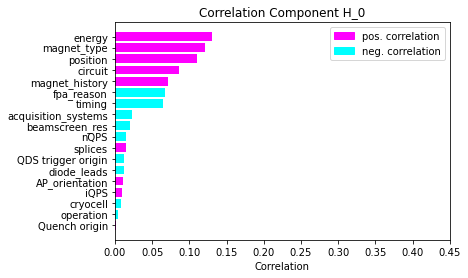

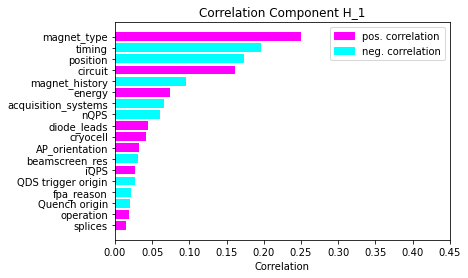

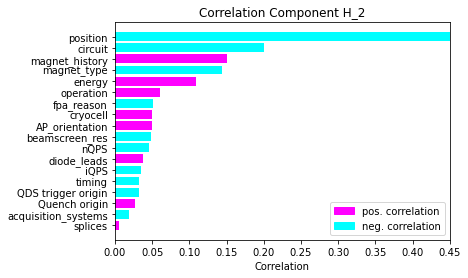

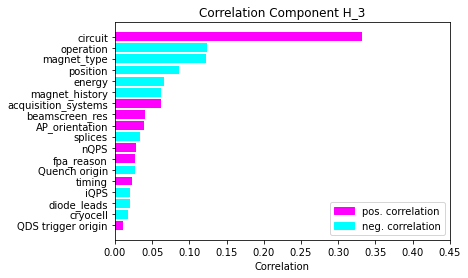

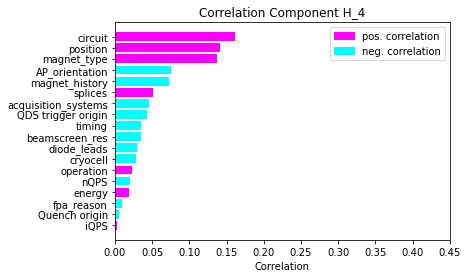

In [37]:
# plot correlation
for c_H in c_columns:
    n_plot_columns = 10
    
    correlation = pd.concat([df_corr[c_H].abs(), df_corr["group"]], axis=1)
    correlation_sorted = correlation.sort_values(by=c_H, ascending=False).drop(index=c_columns).drop_duplicates(subset="group")
    
    sign_of_corr = (df_corr.loc[correlation_sorted.index.values, c_H] > 0).values
    color_of_corr = [mpl.cm.cool(256) if s else mpl.cm.cool(0) for s in sign_of_corr]
    
    
    high_corr = correlation_sorted[correlation_sorted[c_H] > 0.1][["group",c_H]].values
    pm_corr = ["+" if s else "-" for s in sign_of_corr]
    print(c_H)
    [print(f"{c[0]} ({pm_corr[i]}{c[1]:.2f})") for i, c in enumerate(high_corr)]
    
    plt.figure()
    plt.barh(correlation_sorted.group.values[::-1], correlation_sorted[c_H].values[::-1], color=color_of_corr[::-1])
    plt.title(f"Correlation Component {c_H}")
    plt.xlabel('Correlation')
    
    pos_corr = mpatches.Patch(color=mpl.cm.cool(256), label='pos. correlation')
    neg_corr = mpatches.Patch(color=mpl.cm.cool(0), label='neg. correlation')
    plt.legend(handles=[pos_corr,neg_corr])
    
    plt.xlim((0,0.45))

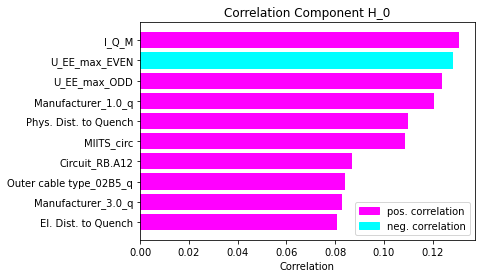

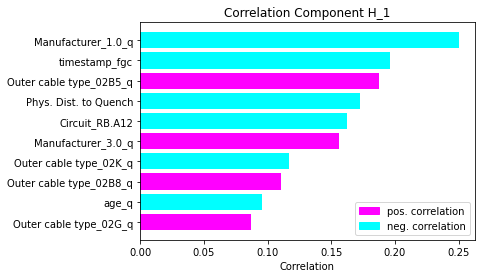

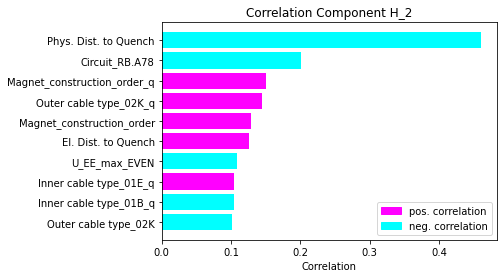

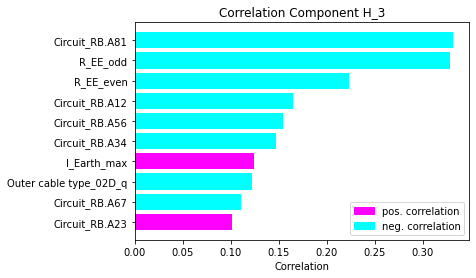

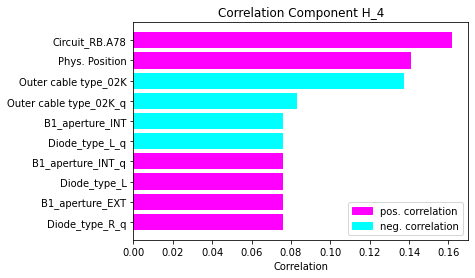

In [22]:
# plot correlation
for c_H in c_columns:
    n_plot_columns = 10
    
    correlation = df_corr[c_H].abs().sort_values(ascending=False).drop(index=c_columns)
    sign_of_corr = (df_corr.loc[correlation.index.values[:10], c_H] > 0).values
    color_of_corr = [mpl.cm.cool(256) if s else mpl.cm.cool(0) for s in sign_of_corr]
    
    
    plt.figure()
    plt.barh(correlation.index.values[:n_plot_columns][::-1], correlation.values[:n_plot_columns][::-1], color= color_of_corr)
    plt.title(f"Correlation Component {c_H}")
    plt.xlabel('Correlation')
    
    pos_corr = mpatches.Patch(color=mpl.cm.cool(256), label='pos. correlation')
    neg_corr = mpatches.Patch(color=mpl.cm.cool(0), label='neg. correlation')
    plt.legend(handles=[pos_corr,neg_corr])